In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%pylab inline
#mpl.style.use('classic')


Populating the interactive namespace from numpy and matplotlib


In [2]:
mainpath='../csse_covid_19_data/csse_covid_19_time_series/'

In [3]:
def getCountryStats(country='World'):
    data=dict()

    for case in ['Confirmed','Deaths','Recovered']:            
        df=pd.read_csv(mainpath+'time_series_19-covid-{}.csv'.format(case))
        days=df.columns[4:]
        
        if country.lower()!='world':
            isCountry=df['Country/Region']==country
            df=df[isCountry]
            
        data[case]= {'days':days,'people':np.array(df[days].sum())}   
    
    start=data['Confirmed']['people']>0
    print('COVID-19 first day in {}: {}'.format(country,data['Confirmed']['days'][start][0])) 
    
    print('TOTAL CASES IN {}'.format(country.upper()))
    print('================')
    for case in ['Confirmed','Deaths','Recovered']:
        print('{:9s}: {:6d}'.format(case,int(max(data[case]['people']))))
        
    plt.figure(figsize=(18,6))       
    for case in ['Confirmed','Deaths','Recovered']:
        plt.plot_date(data[case]['days'][start],data[case]['people'][start],'-o',label=case)
    plt.title('{} COVID-19 cases'.format(country))
    plt.ylabel('Cases')
    plt.xlabel('Days')
    plt.legend()
    plt.tight_layout()
    plt.grid(linestyle='--')
    if max(data['Confirmed']['people'])>15000:
        plt.yscale('log')
    if len(data[case]['days'][start])>30:
        plt.xticks(data[case]['days'][start][::2])
    plt.tick_params(axis='x',rotation=90)
    plt.savefig('Plots/{}.png'.format(country.lower()),bbox_inches = "tight")
    return data

# World

COVID-19 first day in World: 1/22/20
TOTAL CASES IN WORLD
Confirmed: 335955
Deaths   :  14632
Recovered:  97704


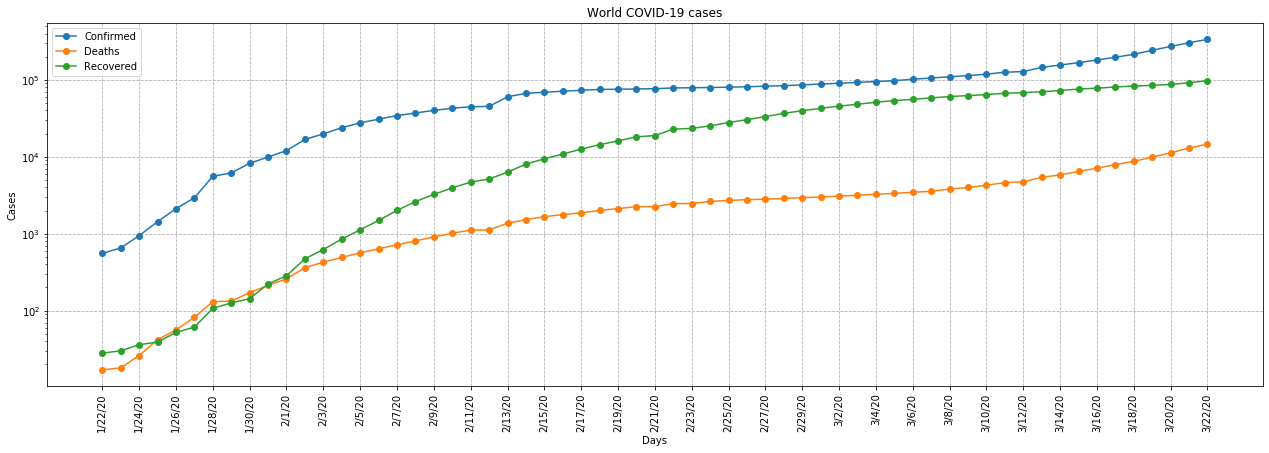

In [4]:
stats=getCountryStats()

# Mexico

COVID-19 first day in Mexico: 2/28/20
TOTAL CASES IN MEXICO
Confirmed:    251
Deaths   :      2
Recovered:      4


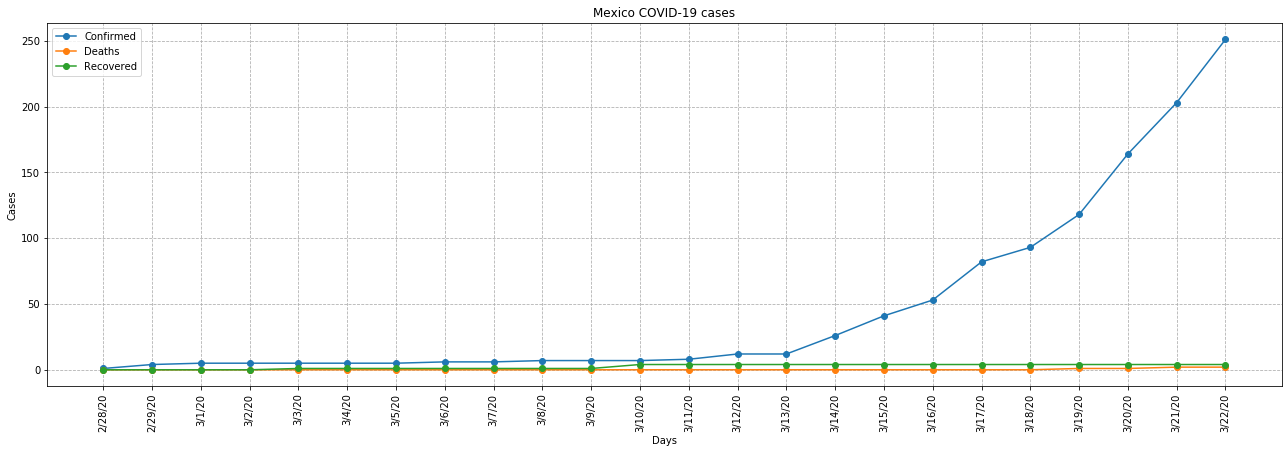

In [5]:
mxStats=getCountryStats('Mexico')

COVID-19 first day in Spain: 2/1/20
TOTAL CASES IN SPAIN
Confirmed:  28768
Deaths   :   1772
Recovered:   2575


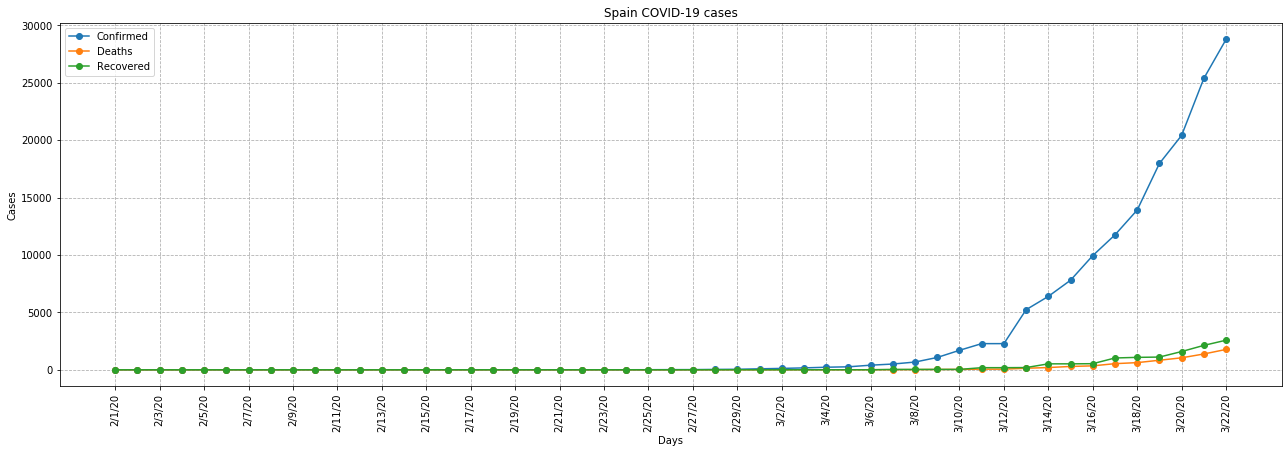

In [6]:
spStats=getCountryStats('Spain')
plt.yscale('linear')

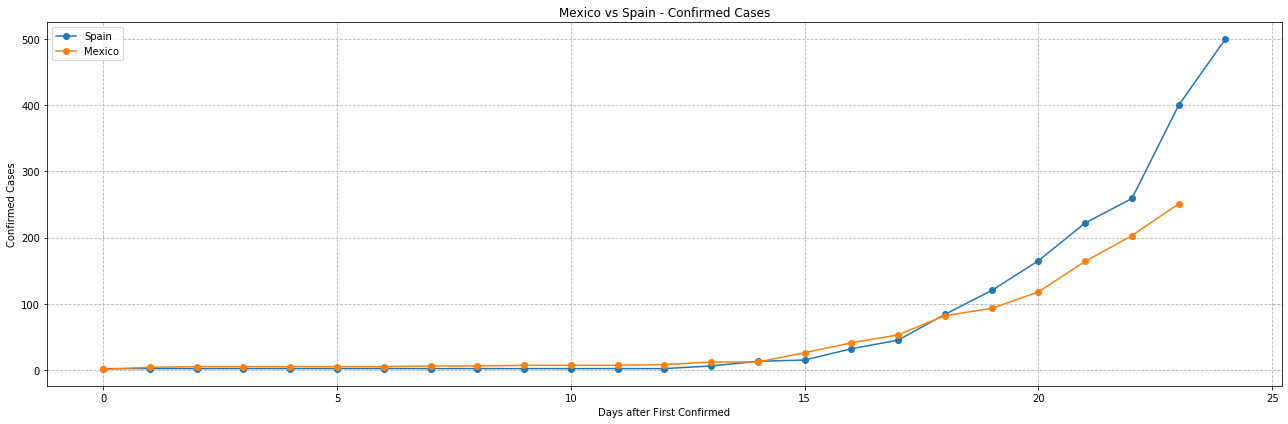

In [7]:
plt.figure(figsize=(18,6))       
mx=mxStats['Confirmed']['people']>0
sp=spStats['Confirmed']['people']>0
daysSp=np.arange(25)
daysMx=np.arange(len(mxStats['Confirmed']['days'][mx]))
plt.plot(daysSp,spStats['Confirmed']['people'][sp][11:36],'-o',label='Spain')
plt.plot(daysMx,mxStats['Confirmed']['people'][mx],'-o',label='Mexico')
plt.title('Mexico vs Spain - Confirmed Cases')
plt.ylabel('Confirmed Cases')
plt.xlabel('Days after First Confirmed')
plt.grid(linestyle='--')
plt.legend()
plt.tight_layout()
plt.savefig('Plots/spvsmx_confirmed.png')

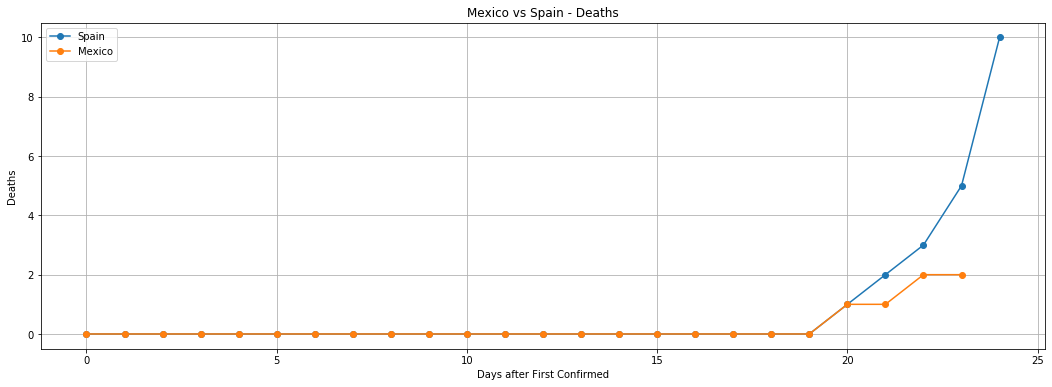

In [8]:
plt.figure(figsize=(18,6))
plt.title('Mexico vs Spain - Deaths')
plt.plot(daysSp,spStats['Deaths']['people'][sp][11:36],'-o',label='Spain')
plt.plot(daysMx,mxStats['Deaths']['people'][mx],'-o',label='Mexico')
plt.ylabel('Deaths')
plt.xlabel('Days after First Confirmed')
plt.grid()
plt.legend()
plt.savefig('Plots/spvsmx_deaths.png')